## Process gridded product for fast visualization

In [217]:
import warnings
warnings.filterwarnings('ignore')

# import icepyx as ipx
import earthaccess
import h5py
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import mpl

from pyproj import Proj, transform
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

from readers import *

# %matplotlib widget
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
auth = earthaccess.login()

Enter your Earthdata Login username:  younghyunkoo
Enter your Earthdata password:  ········


In [5]:
Query = earthaccess.collection_query().keyword('ICESat-2')

In [6]:
Query.hits()

56

In [7]:
Query = earthaccess.collection_query().keyword('ATL10').cloud_hosted(True)
print(Query.hits())
collections = Query.fields(['ShortName', 'Version']).get(25)
print(collections)

3
[{
  "meta": {
    "concept-id": "C2613553243-NSIDC_CPRD",
    "granule-count": 46487,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL10",
    "Version": "006"
  }
}, {
  "meta": {
    "concept-id": "C2753295020-NSIDC_CPRD",
    "granule-count": 124,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL20",
    "Version": "004"
  }
}, {
  "meta": {
    "concept-id": "C2753316241-NSIDC_CPRD",
    "granule-count": 124,
    "provider-id": "NSIDC_CPRD"
  },
  "umm": {
    "ShortName": "ATL21",
    "Version": "003"
  }
}]


In [59]:
# Query Antarctic ATL20 data using earthaccess (September)
Query = earthaccess.granule_query().concept_id(
    'C2753295020-NSIDC_CPRD'
).temporal("2022-07-01 T10:00:00", "2022-09-30 T23:00:00"
).bounding_box(-180, -90, 180, -60)

granules = Query.get()
granules

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard V004'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.999997, 'EastBoundingCoordinate': 179.999999, 'NorthBoundingCoordinate': -58.376193, 'SouthBoundingCoordinate': -78.556091}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-01T01:13:50.185Z', 'EndingDateTime': '2022-08-01T00:47:11.789Z'}}
 Size(MB): 2.7710342407226562
 Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/004/2022/07/01/ATL20-02_20220701000935_01391601_004_01.h5'],
 Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard V004'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.999998, 'EastBoundingCoordinate': 179.999996, 'NorthBoundingCoordinate': -55.45344, 'SouthBoundingCoordinate': -78.55264}]}

In [179]:
files = earthaccess.open(granules)
files

Opening 3 granules, approx size: 0.01 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 414.27it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


[<File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/004/2022/07/01/ATL20-02_20220701000935_01391601_004_01.h5>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/004/2022/08/01/ATL20-02_20220801010257_06131601_004_01.h5>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL20/004/2022/09/01/ATL20-02_20220901002201_10861601_004_01.h5>]

In [202]:
first = True

years = np.ones(36)
months = np.ones(36)

for j, year in enumerate([2019, 2020, 2021, 2022]):
    # Query Antarctic ATL20 data using earthaccess (September)
    Query = earthaccess.granule_query().concept_id(
        'C2753295020-NSIDC_CPRD'
    ).temporal(f"{year}-04-01 T10:00:00", f"{year}-12-30 T23:00:00"
    ).bounding_box(-180, -90, 180, -60)
    
    granules = Query.get()
    files = earthaccess.open(granules)
    print(year, len(files))
    
    for i, file in enumerate(files):
        with h5py.File(file, 'r') as f:
    
            if first:            
            
                lat = f['grid_lat'][:]
                lon = f['grid_lon'][:]
                
                # Spatial reference: NSIDC Sea Ice Polar Stereographic North (EPSG:3411)
                x = f['grid_x'][:]
                y = f['grid_y'][:]
                xx, yy = np.meshgrid(x, y)
    
                fb = f['monthly']['mean_fb'][:]
                fb[fb > 10] = np.nan
                
                mean_fb = np.zeros((len(files)*4, xx.shape[0], xx.shape[1]))
    
                first = False
                
            else:
                fb = f['monthly']['mean_fb'][:]
                fb[fb > 10] = np.nan
                
            mean_fb[i+len(files)*j] = fb
            years[i+len(files)*j] = year
            months[i+len(files)*j] = i+4
    
    # ## Three-year mean
    # mean_fb3 = np.nanmean(mean_fb, axis = 0)

print("DONE!")

Opening 9 granules, approx size: 0.02 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 898.76it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.79it/s]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


2019 9
Opening 9 granules, approx size: 0.02 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 564.86it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.23it/s]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


2020 9
Opening 9 granules, approx size: 0.02 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 963.20it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.32it/s]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


2021 9
Opening 9 granules, approx size: 0.02 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 575.75it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.41it/s]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


2022 9
DONE!


In [203]:
months

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

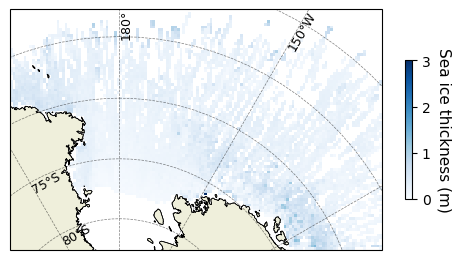

In [224]:
fig=plt.figure(figsize=(6, 6))

# Use the in-built northpolarstereo to visualize (true scale latitude is from NSIDC polar stereographic)
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70))

pm  = ax.pcolormesh(xx ,yy, mean_fb3, vmin = 0, vmax = 3.0, cmap = "Blues")
ax.coastlines('10m', linewidth = 0.5) # add coastline
# Add gridline
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')

# mpl.gridliner.Gridliner._update_labels_visibility()
for artist in gl.top_label_artists:
    artist.set_visible(True)

gl.ylabel_style = {'size': 9, 'color': 'k', 'ha': 'left', 'rotation': 30}
gl.xlabel_style = {'size': 9, 'color': 'k', 'ha': 'center', 'rotation': 0}
gl.top_labels = False #True #False #False #False
gl.bottom_labels = False #False #False
# gl.xlabels_left = True #False
# gl.xlabels_right = True #False
# gl.ylabels_left = False #True #False
# gl.ylabels_right = False #True #False
# gl.ylabels_top = False #True #False
# gl.ylabels_bottom = False #True #False

clb = plt.colorbar(pm, ax = ax, shrink = 0.3)
clb.set_label('Sea ice thickness (m)', rotation = 270, fontsize = 11, va = 'bottom')

ax.coastlines('10m', linewidth = 0.5)
ax.add_feature(cfeature.LAND)

xmin, xmax = ax.set_xlim(1000000, -2400000)
ymin, ymax = ax.set_ylim(-800000, -3000000)

ax.annotate('180°', xy=(0.33, 1.0), xycoords='axes fraction', rotation = 90, size = 9, va = 'top', ha ='right')
ax.annotate('150°W',xy=(0.83, 1.0), xycoords='axes fraction', rotation = 60, size = 9, va = 'top', ha ='right')

plt.show()

In [218]:
hs = snow_depth(mean_fb3, xx, yy, dt.datetime(year, month+1, 1), method = "KK")
hi = ice_thickness(mean_fb3, hs)

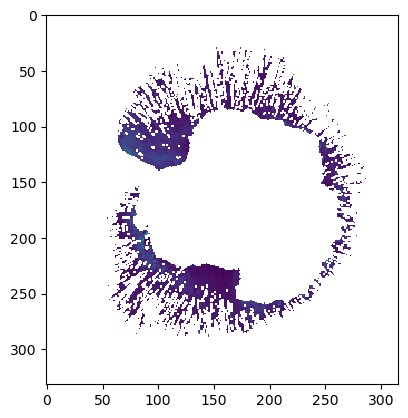

In [219]:
plt.imshow(hi)

4it [00:00,  6.96it/s]


DONE!


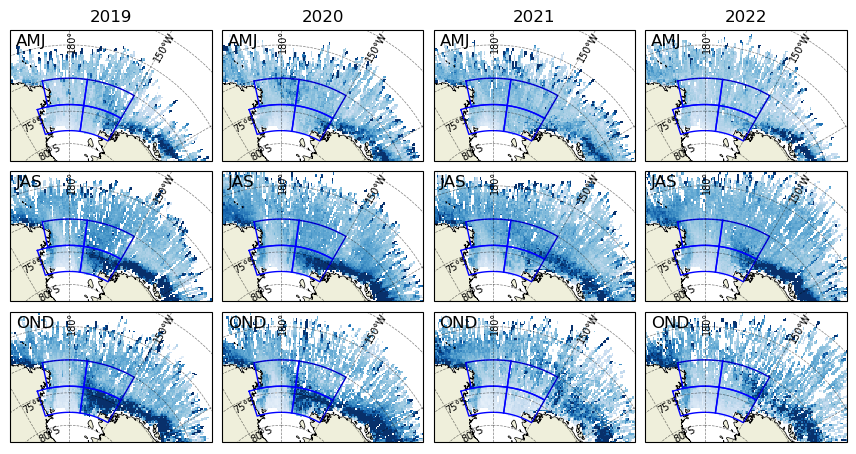

In [220]:
## Set-up projection for 4 sub-sectors =============================
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3412")
offset = 0.0

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)
## ========================================================

fig, ax = plt.subplots(3, 4, figsize = (4*2.7, 3*1.8), dpi= 100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

month_labels = ["AMJ", "JAS", "OND"]

for j, year in tqdm(enumerate([2019, 2020, 2021, 2022])):
    
    for i, month in enumerate([4, 7, 10]):     

        idx = (years == year) & (months >= month) & (months <= month+2)
        mean_fb3 = np.nanmean(mean_fb[idx], axis = 0)

        hs = snow_depth(mean_fb3, xx, yy, dt.datetime(year, month+1, 1), method = "KK")
        hi = ice_thickness(mean_fb3, hs)
        
        pm = ax[i,j].pcolormesh(xx, yy, hi, cmap='Blues', vmin=0, vmax=3.0)
        
        ax[i,j].coastlines('10m', linewidth = 0.5)
        ax[i,j].add_feature(cfeature.LAND)

        ax[i,j].plot(NW_x, NW_y, lw=1, color = "b")
        ax[i,j].plot(NE_x, NE_y, lw=1, color = "b")
        ax[i,j].plot(SW_x, SW_y, lw=1, color = "b")
        ax[i,j].plot(SE_x, SE_y, lw=1, color = "b")

        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                               linewidth=0.5, color='k', alpha = 0.5, linestyle='--')

        # gl.xformatter = LONGITUDE_FORMATTER
        # gl.yformatter = LATITUDE_FORMATTER
        # gl.xlabel_style = {'size': 12, 'color': 'gray'}
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 30}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False

        ax[i,j].annotate('180°', xy=(0.33, 1.0), xycoords='axes fraction', rotation = 90, size = 7, va = 'top', ha ='right')
        ax[i,j].annotate('150°W',xy=(0.83, 1.0), xycoords='axes fraction', rotation = 60, size = 7, va = 'top', ha ='right')

        # xmin, xmax = ax.set_xlim(900000, -1400000)
        # ymin, ymax = ax.set_ylim(-1000000, -2500000)

        # plt.xlim(1000000, -2400000) plt.ylim( -800000, -3000000)
        xmin, xmax = ax[i,j].set_xlim(1000000, -2400000) #xlim(1000000, -1600000)
        ymin, ymax = ax[i,j].set_ylim(-800000, -3000000) #ylim(-800000, -3000000)

        ax[i,j].annotate(month_labels[i], xy=(0.03, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        if i == 0:
            ax[i,j].set_title("{0}".format(year), fontsize = 12)
        # print(year, month)
plt.savefig('D:\\Ross\\ice_motion\\SIT_all_Ross_Amundsen.png', bbox_inches = "tight")
print("DONE!")